In [ ]:
%pip install datasets


   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ------- -------------------------------- 4.5/25.1 MB 22.3 MB/s eta 0:00:01
   --------------- ------------------------ 10.0/25.1 MB 23.0 MB/s eta 0:00:01
   -------------------------- ------------- 16.5/25.1 MB 24.8 MB/s eta 0:00:01
   -------------------------------------- - 23.9/25.1 MB 27.0 MB/s eta 0:00:01
   ---------------------------------------- 25.1/25.1 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.1 requires torch==2.5.1, but you have torch 2.2.2 which is incompatible.


In [101]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [96]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x) 
        x = torch.sigmoid(self.fc(x))
        
        return x

In [ ]:
dataset = load_dataset('imdb') 
train_data = dataset['train']
test_data = dataset['test']
train_data.data

MemoryMappedTable
text: string
label: int64
----
text: [["I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Real

In [117]:


tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_data['text']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(text):
    return vocab(tokenizer(text))

def process_data(texts, labels, vocab, tokenizer, max_seq_len): 
    data = [(torch.tensor(text_pipeline(text)[:max_seq_len] + [0]*(max_seq_len - len(text_pipeline(text)))), torch.tensor(label)) for text, label in zip(texts, labels)] 
    texts, labels = zip(*data) 
    return TensorDataset(torch.stack(texts), torch.stack(labels)) 

train_dataset = process_data(train_data['text'], train_data['label'], vocab, tokenizer, 128) 
test_dataset = process_data(test_data['text'], test_data['label'], vocab, tokenizer, 128)


In [118]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNNModel(vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=1).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

loaders = {"train": train_dataloader, "test": test_dataloader}


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [119]:
max_epoch = 10
accuracy = {"train": [], "test": []}

for epoch in range(max_epoch):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float().unsqueeze(1)
         
            if k == "train":
                model.train()
                optimizer.zero_grad()
                
                outp = model(x_batch)
                
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = (outp >= 0.5).float()
            correct = (preds == y_batch).sum()
            total = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += total
            # f1 = f1_score(preds.cpu().numpy(), y_batch.cpu().numpy())
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.54352
Loader: test. Accuracy: 0.5726
Epoch: 2
Loader: train. Accuracy: 0.5866
Loader: test. Accuracy: 0.59412
Epoch: 3
Loader: train. Accuracy: 0.65344
Loader: test. Accuracy: 0.67268
Epoch: 4
Loader: train. Accuracy: 0.682
Loader: test. Accuracy: 0.58488
Epoch: 5
Loader: train. Accuracy: 0.67584
Loader: test. Accuracy: 0.69516
Epoch: 6
Loader: train. Accuracy: 0.77268
Loader: test. Accuracy: 0.78436
Epoch: 7
Loader: train. Accuracy: 0.8506
Loader: test. Accuracy: 0.80884
Epoch: 8
Loader: train. Accuracy: 0.9058
Loader: test. Accuracy: 0.8176
Epoch: 9
Loader: train. Accuracy: 0.9412
Loader: test. Accuracy: 0.8058
Epoch: 10
Loader: train. Accuracy: 0.96316
Loader: test. Accuracy: 0.81384


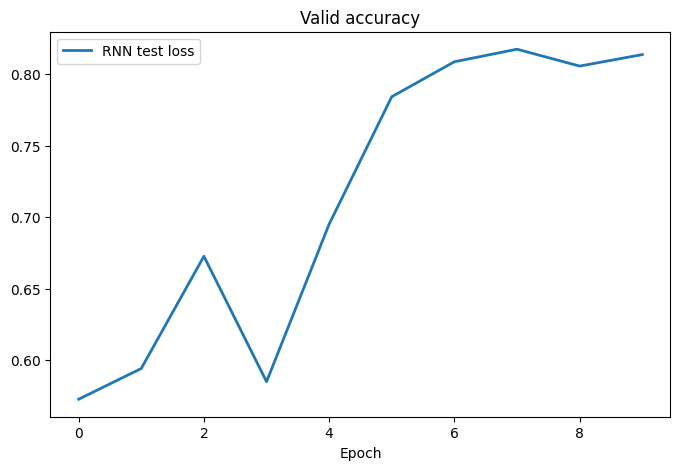

In [122]:
plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epoch), accuracy['test'], label="RNN test loss", linewidth=2)
#plt.plot(range(max_epoch), accuracy['train'], label="RNN train loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()